# Regression with Fourier Features

Initially observed in: https://arxiv.org/abs/2006.10739

The inclusion of Fourier features allows neural networks to capture high frequency information of the target function. In this short note, we compare a vanilla DNN with another Fourier-feature embedded DNN on the task of learning a (noise-perturbed) high frequency function.

This notebook should be self-contained.

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy
from collections import OrderedDict

# set random seeds
np.random.seed(10)
torch.manual_seed(10);
torch.set_default_dtype(torch.float64)

import numpy as np    
import matplotlib.pyplot as plt

import time
import pylab as pl
from IPython import display
from IPython.display import clear_output

In [28]:
# define vanilla deep neural net
class DNN(torch.nn.Module):
    def __init__(
        self, layers, 
        activation=torch.nn.Tanh, 
        last_layer_activation=None,
        initialization=None
    ):
        """ 
            Custom initialization of neural network layers with the option 
            of changing the output layer's activation function.
        """
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = activation
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        if last_layer_activation is not None:
            layer_list.append(
            ('activation_%d' % (self.depth - 1), last_layer_activation())
        )

        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
        # custom initialization modes
        self.initialize(mode=initialization)
        
        
    def forward(self, x):
        return self.layers(x)
    
    def initialize(self, mode):
        if mode == None:
            return
        else:
            for layer in self.layers:
                if isinstance(layer, torch.nn.Linear):
                    # initialize depending on mode
                    if mode == "xavier":
                        torch.nn.init.xavier_uniform_(layer.weight)
                    elif mode == "kaiming":
                        torch.nn.init.kaiming_uniform_(layer.weight)
                    elif mode == "normal":
                        torch.nn.init.normal_(layer.weight)
                    elif mode == "uniform":
                        torch.nn.init.uniform_(layer.weight)
                    elif mode == "ones":
                        torch.nn.init.ones_(layer.weight)
                    else:
                        raise NotImplementedError()
            return
        
class FourierEmbeddedDNN(torch.nn.Module):
    def __init__(self, 
                 layers, 
                 activation=torch.nn.Tanh, 
                 last_layer_activation=None, 
                 initialization=None,
                 m=1,
                 freq_stds=None):
        super(FourierEmbeddedDNN, self).__init__()
        # fourier embedding is applied prior to passing into neural net, 
        # need to make sure dimensions match
        assert layers[0] == 2*m
        # build main DNN
        self.layer_spec = layers
        self.layers = self.build_nn(
            layers, activation, last_layer_activation, initialization
        )
        # build fourier feature embedding
        self.fourier_embedding = self.build_embedding(m, freq_stds)
        
        # build final aggregator to combine outputs of different scale fourier embeddings
        self.build_aggregator()
    
    def build_nn(self, layers, activation, last_layer_activation, initialization):
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = activation
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        if last_layer_activation is not None:
            layer_list.append(
            ('activation_%d' % (self.depth - 1), last_layer_activation())
        )

        layerDict = OrderedDict(layer_list)
        return torch.nn.Sequential(layerDict)
    
    def build_embedding(self, num_freqs, freq_stds):
        # number of feature embeddings correspond to length of standard 
        # deviations specified. If `None`, by default uses only 1 embedding
        # standard Gaussian.
        if freq_stds:
            self.num_embeddings = len(freq_stds)
        else:
            self.num_embeddings = 1
            freq_stds = [1.0]
        # draw frequency matrix
        freq_matrix = [torch.randn(num_freqs, requires_grad=False) for _ in range(self.num_embeddings)]
        for i in range(self.num_embeddings):
            # scale by frequency standard deviation
            freq_matrix[i] = torch.tensor(freq_stds[i])*freq_matrix[i]
        return freq_matrix
    
    def build_aggregator(self):
        # number of fourier embeddings
        k = self.num_embeddings
        # size of hidden layer final outputs
        num_out = self.layer_spec[-1]
        # create trainable aggregating weights for each embedding (simple linear aggregation
        # , may also consider computing another nonlinear activation for each embedding, then 
        # summing all outputs).
        self.aggregator = torch.nn.Linear(num_out*k, 1)
        
    def fourier_lifting(self, x, freq):
        # input x has size (N x 1), output has size (N x 2*m) where m is number of Fourier bases
        
        # has size (N x m)
        x = freq * x
        # lift to sin and cos space
        x = torch.concat(
            [
                torch.cos(2*torch.pi*x), 
                torch.sin(2*torch.pi*x)
            ], dim=1
        )
        return x
    
    def forward(self, x):
        # inputs x has size (N x 1)
        # create Fourier features
        lifted = []
        for i in range(self.num_embeddings):
            lifted.append(self.fourier_lifting(x, self.fourier_embedding[i]))
        # lifted is a length-k list of (N x 2*m) tensors of lifted features according to 
        # k different scales.
        
        # now pass each (N x 2*m) features into the hidden layers
        for i in range(self.num_embeddings):
            lifted[i] = self.layers(lifted[i])
        
        # lifted is a length-k list of (N x num_out) tensor of transformed fourier features
        # now concatenate into (N x num_out*k) and pass into aggregator to obtain (N x 1) prediction
        lifted = torch.concat(lifted, dim=1)
        # final aggregation
        lifted = self.aggregator(lifted)
        return lifted

Generate data

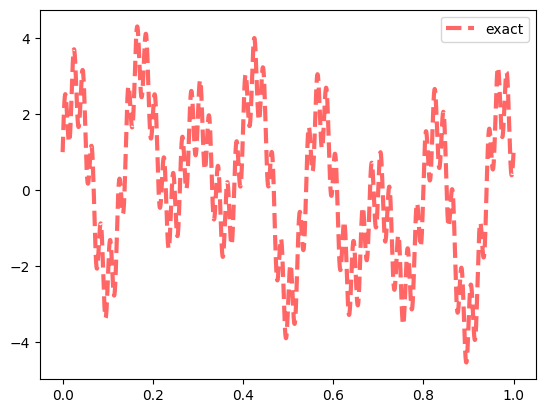

In [44]:
# your code here

# oscillations with decay
#f = lambda x: 100*(np.exp(-2.0*x)*np.sin(10*np.pi*x))+np.cos(5.0*np.pi*x)

# different frequencies
f = lambda x: np.sin(2*np.pi*x) + np.cos(10.*np.pi*x) + 2.0*np.sin(15.*np.pi*x) + np.sin(100.0*np.pi*x)

# linear function
#f = lambda x: 10.0*x
x_start, x_end = 0.0, 1.0
nx = 2048
xgrid = np.linspace(x_start, x_end, nx)
dx = xgrid[1]-xgrid[0]
# visualize function with noise perturbation
f_data = f(xgrid)
noise_level = 0.0
f_data = f_data + noise_level * np.random.randn(f_data.shape[0])
plt.plot(xgrid, f_data, "--", color="red", lw=3.0, label="exact", alpha=0.6);
plt.legend();

In [45]:
# training data
inputs = torch.tensor(xgrid).reshape(-1, 1)
outputs = torch.tensor(f_data).reshape(-1, 1)

# define training function
def train(inputs, outputs, model, optim, scheduler, batch_size, epochs, shuffle=True):
    X, y = inputs, outputs
    nx = X.shape[0]
    num_batches = int(nx/batch_size)
    for i in range(epochs):
        print("============================================================\n")
        print("Epoch = {}\n".format(i+1));
        print("============================================================\n")
        model.train()
        if shuffle:
            tmp = np.random.permutation(nx)
            X, y = X[tmp, :].data.clone(), y[tmp, :].data.clone()
        for idx in range(num_batches):
            print("| => | Batch {} |\n".format(idx+1))
        # closure definition
            def closure():
                optim.zero_grad()
                start_idx = idx*batch_size
                end_idx = (idx+1)*batch_size
                if idx + 1 == num_batches:
                    # if last batch
                    end_idx = -1
                Xb, yb = X[start_idx:end_idx, :].data.clone(), y[start_idx:end_idx, :].data.clone()

                # require gradients
                Xb.requires_grad = True
                # make a prediction on the batch
                y_pred = model.forward(Xb)
                # compute L^2 loss
                loss = torch.mean((y_pred - yb)**2)
                # backpropagate
                loss.backward()
                print("==> Batch {} loss = {}".format(idx, loss.item()))
                return loss
            optim.step(closure=closure)
        if scheduler:
            # step scheduler after epoch if there is one
            scheduler.step()
            print("---------- \n")
            print("++ Learning rate reduced, now at = {}".format(scheduler.get_last_lr()[0]))

Testing neural net performance

In [46]:
# vanilla PINN: initialize optimizer and scheduler
nn_vanilla = DNN(layers=[1, 128, 128, 128, 1])
optim = torch.optim.Adam(
    nn_vanilla.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
train(inputs, outputs, nn_vanilla, optim, scheduler, 2**10, 500, shuffle=False)


Epoch = 1


| => | Batch 1 |

==> Batch 0 loss = 3.956295842874241
| => | Batch 2 |

==> Batch 1 loss = 11.012131856475504
---------- 

++ Learning rate reduced, now at = 0.0079992

Epoch = 2


| => | Batch 1 |

==> Batch 0 loss = 5.67791213726915
| => | Batch 2 |

==> Batch 1 loss = 3.852707488209644
---------- 

++ Learning rate reduced, now at = 0.007998400079999999

Epoch = 3


| => | Batch 1 |

==> Batch 0 loss = 4.583756827890049
| => | Batch 2 |

==> Batch 1 loss = 3.802496533962568
---------- 

++ Learning rate reduced, now at = 0.007997600239991999

Epoch = 4


| => | Batch 1 |

==> Batch 0 loss = 3.346218629304337
| => | Batch 2 |

==> Batch 1 loss = 4.833649608816145
---------- 

++ Learning rate reduced, now at = 0.007996800479968

Epoch = 5


| => | Batch 1 |

==> Batch 0 loss = 3.334635673925173
| => | Batch 2 |

==> Batch 1 loss = 4.264169319634595
---------- 

++ Learning rate reduced, now at = 0.007996000799920003

Epoch = 6


| => | Batch 1 |

==> Batch 0 loss = 3.42

==> Batch 1 loss = 3.4415377580317275
---------- 

++ Learning rate reduced, now at = 0.007969656172571013

Epoch = 39


| => | Batch 1 |

==> Batch 0 loss = 3.188464456025904
| => | Batch 2 |

==> Batch 1 loss = 3.442791963884722
---------- 

++ Learning rate reduced, now at = 0.007968859206953756

Epoch = 40


| => | Batch 1 |

==> Batch 0 loss = 3.1805061449618153
| => | Batch 2 |

==> Batch 1 loss = 3.442308707247383
---------- 

++ Learning rate reduced, now at = 0.007968062321033061

Epoch = 41


| => | Batch 1 |

==> Batch 0 loss = 3.173978464787674
| => | Batch 2 |

==> Batch 1 loss = 3.4405593350733485
---------- 

++ Learning rate reduced, now at = 0.007967265514800958

Epoch = 42


| => | Batch 1 |

==> Batch 0 loss = 3.1682927849350264
| => | Batch 2 |

==> Batch 1 loss = 3.439338236165823
---------- 

++ Learning rate reduced, now at = 0.007966468788249479

Epoch = 43


| => | Batch 1 |

==> Batch 0 loss = 3.161367400937128
| => | Batch 2 |

==> Batch 1 loss = 3.4396342380

| => | Batch 2 |

==> Batch 1 loss = 3.369606980341328
---------- 

++ Learning rate reduced, now at = 0.007938633495881052

Epoch = 78


| => | Batch 1 |

==> Batch 0 loss = 2.852847306015332
| => | Batch 2 |

==> Batch 1 loss = 3.3629563853427697
---------- 

++ Learning rate reduced, now at = 0.007937839632531463

Epoch = 79


| => | Batch 1 |

==> Batch 0 loss = 2.8635054028806737
| => | Batch 2 |

==> Batch 1 loss = 3.3561322124672324
---------- 

++ Learning rate reduced, now at = 0.00793704584856821

Epoch = 80


| => | Batch 1 |

==> Batch 0 loss = 2.8761719793864176
| => | Batch 2 |

==> Batch 1 loss = 3.348141692365889
---------- 

++ Learning rate reduced, now at = 0.007936252143983354

Epoch = 81


| => | Batch 1 |

==> Batch 0 loss = 2.8843476481720067
| => | Batch 2 |

==> Batch 1 loss = 3.340375133729234
---------- 

++ Learning rate reduced, now at = 0.007935458518768956

Epoch = 82


| => | Batch 1 |

==> Batch 0 loss = 2.8760351815831946
| => | Batch 2 |

==> Batch 1 

==> Batch 1 loss = 3.0624196462779563
---------- 

++ Learning rate reduced, now at = 0.007907731578035399

Epoch = 117


| => | Batch 1 |

==> Batch 0 loss = 2.6278425685419773
| => | Batch 2 |

==> Batch 1 loss = 2.666903081248085
---------- 

++ Learning rate reduced, now at = 0.007906940804877595

Epoch = 118


| => | Batch 1 |

==> Batch 0 loss = 2.575169374149743
| => | Batch 2 |

==> Batch 1 loss = 2.4975623617291016
---------- 

++ Learning rate reduced, now at = 0.007906150110797107

Epoch = 119


| => | Batch 1 |

==> Batch 0 loss = 2.6299497276200627
| => | Batch 2 |

==> Batch 1 loss = 2.559962423930295
---------- 

++ Learning rate reduced, now at = 0.007905359495786028

Epoch = 120


| => | Batch 1 |

==> Batch 0 loss = 2.6099240810721693
| => | Batch 2 |

==> Batch 1 loss = 2.7221202841525773
---------- 

++ Learning rate reduced, now at = 0.007904568959836449

Epoch = 121


| => | Batch 1 |

==> Batch 0 loss = 2.5559346288588634
| => | Batch 2 |

==> Batch 1 loss = 2.88

==> Batch 0 loss = 2.407913382577404
| => | Batch 2 |

==> Batch 1 loss = 2.207898117862099
---------- 

++ Learning rate reduced, now at = 0.007875374637748

Epoch = 158


| => | Batch 1 |

==> Batch 0 loss = 2.3690743909810674
| => | Batch 2 |

==> Batch 1 loss = 2.2274462191144777
---------- 

++ Learning rate reduced, now at = 0.007874587100284224

Epoch = 159


| => | Batch 1 |

==> Batch 0 loss = 2.382311953469798
| => | Batch 2 |

==> Batch 1 loss = 2.161989006025453
---------- 

++ Learning rate reduced, now at = 0.007873799641574196

Epoch = 160


| => | Batch 1 |

==> Batch 0 loss = 2.3720299277133394
| => | Batch 2 |

==> Batch 1 loss = 2.1593949983289393
---------- 

++ Learning rate reduced, now at = 0.007873012261610038

Epoch = 161


| => | Batch 1 |

==> Batch 0 loss = 2.3444869012866802
| => | Batch 2 |

==> Batch 1 loss = 2.153513485550376
---------- 

++ Learning rate reduced, now at = 0.007872224960383877

Epoch = 162


| => | Batch 1 |

==> Batch 0 loss = 2.3432118

==> Batch 0 loss = 2.2539319247561367
| => | Batch 2 |

==> Batch 1 loss = 1.8325405684533222
---------- 

++ Learning rate reduced, now at = 0.007843934489382405

Epoch = 198


| => | Batch 1 |

==> Batch 0 loss = 2.2579084448256967
| => | Batch 2 |

==> Batch 1 loss = 1.8243343023435887
---------- 

++ Learning rate reduced, now at = 0.007843150095933466

Epoch = 199


| => | Batch 1 |

==> Batch 0 loss = 2.2612721559395723
| => | Batch 2 |

==> Batch 1 loss = 1.8340718932976268
---------- 

++ Learning rate reduced, now at = 0.007842365780923873

Epoch = 200


| => | Batch 1 |

==> Batch 0 loss = 2.2543392106059916
| => | Batch 2 |

==> Batch 1 loss = 1.8659677174849287
---------- 

++ Learning rate reduced, now at = 0.00784158154434578

Epoch = 201


| => | Batch 1 |

==> Batch 0 loss = 2.2489671512643454
| => | Batch 2 |

==> Batch 1 loss = 1.9436337699934079
---------- 

++ Learning rate reduced, now at = 0.007840797386191346

Epoch = 202


| => | Batch 1 |

==> Batch 0 loss = 2.

==> Batch 1 loss = 1.4647308897657834
---------- 

++ Learning rate reduced, now at = 0.007812619856687459

Epoch = 238


| => | Batch 1 |

==> Batch 0 loss = 2.223202962036789
| => | Batch 2 |

==> Batch 1 loss = 1.3687413357250204
---------- 

++ Learning rate reduced, now at = 0.00781183859470179

Epoch = 239


| => | Batch 1 |

==> Batch 0 loss = 2.21976733235922
| => | Batch 2 |

==> Batch 1 loss = 1.2974760206879496
---------- 

++ Learning rate reduced, now at = 0.00781105741084232

Epoch = 240


| => | Batch 1 |

==> Batch 0 loss = 2.230224187481514
| => | Batch 2 |

==> Batch 1 loss = 1.2443848107510977
---------- 

++ Learning rate reduced, now at = 0.007810276305101236

Epoch = 241


| => | Batch 1 |

==> Batch 0 loss = 2.240974509366671
| => | Batch 2 |

==> Batch 1 loss = 1.1963233930216701
---------- 

++ Learning rate reduced, now at = 0.007809495277470726

Epoch = 242


| => | Batch 1 |

==> Batch 0 loss = 2.2451760927525517
| => | Batch 2 |

==> Batch 1 loss = 1.170677

==> Batch 0 loss = 2.2034470314867907
| => | Batch 2 |

==> Batch 1 loss = 0.9819622802559109
---------- 

++ Learning rate reduced, now at = 0.007781430238578259

Epoch = 278


| => | Batch 1 |

==> Batch 0 loss = 2.193849554812845
| => | Batch 2 |

==> Batch 1 loss = 0.9447651457548909
---------- 

++ Learning rate reduced, now at = 0.007780652095554402

Epoch = 279


| => | Batch 1 |

==> Batch 0 loss = 2.2017856438714682
| => | Batch 2 |

==> Batch 1 loss = 0.9159563395783248
---------- 

++ Learning rate reduced, now at = 0.007779874030344846

Epoch = 280


| => | Batch 1 |

==> Batch 0 loss = 2.2136961682111553
| => | Batch 2 |

==> Batch 1 loss = 0.8763594764709202
---------- 

++ Learning rate reduced, now at = 0.007779096042941812

Epoch = 281


| => | Batch 1 |

==> Batch 0 loss = 2.2123532693980903
| => | Batch 2 |

==> Batch 1 loss = 0.8367126713751947
---------- 

++ Learning rate reduced, now at = 0.0077783181333375175

Epoch = 282


| => | Batch 1 |

==> Batch 0 loss = 2

==> Batch 0 loss = 2.1703764160683714
| => | Batch 2 |

==> Batch 1 loss = 0.6329785900920045
---------- 

++ Learning rate reduced, now at = 0.007751140249995341

Epoch = 317


| => | Batch 1 |

==> Batch 0 loss = 2.1659744475116405
| => | Batch 2 |

==> Batch 1 loss = 0.6282516739272528
---------- 

++ Learning rate reduced, now at = 0.007750365135970342

Epoch = 318


| => | Batch 1 |

==> Batch 0 loss = 2.16465891970794
| => | Batch 2 |

==> Batch 1 loss = 0.6383198986514743
---------- 

++ Learning rate reduced, now at = 0.007749590099456746

Epoch = 319


| => | Batch 1 |

==> Batch 0 loss = 2.1635067747345835
| => | Batch 2 |

==> Batch 1 loss = 0.6708963247011209
---------- 

++ Learning rate reduced, now at = 0.0077488151404468

Epoch = 320


| => | Batch 1 |

==> Batch 0 loss = 2.164833049077756
| => | Batch 2 |

==> Batch 1 loss = 0.7373727466084455
---------- 

++ Learning rate reduced, now at = 0.007748040258932756

Epoch = 321


| => | Batch 1 |

==> Batch 0 loss = 2.1832

==> Batch 0 loss = 2.1731112727230286
| => | Batch 2 |

==> Batch 1 loss = 0.608649748278566
---------- 

++ Learning rate reduced, now at = 0.007720196071378833

Epoch = 357


| => | Batch 1 |

==> Batch 0 loss = 2.165385488581439
| => | Batch 2 |

==> Batch 1 loss = 0.7055826618552314
---------- 

++ Learning rate reduced, now at = 0.007719424051771695

Epoch = 358


| => | Batch 1 |

==> Batch 0 loss = 2.1580326190158354
| => | Batch 2 |

==> Batch 1 loss = 0.882198265776432
---------- 

++ Learning rate reduced, now at = 0.007718652109366518

Epoch = 359


| => | Batch 1 |

==> Batch 0 loss = 2.1891123547744487
| => | Batch 2 |

==> Batch 1 loss = 0.9655349450762457
---------- 

++ Learning rate reduced, now at = 0.007717880244155581

Epoch = 360


| => | Batch 1 |

==> Batch 0 loss = 2.2316845986232408
| => | Batch 2 |

==> Batch 1 loss = 0.8765751929227895
---------- 

++ Learning rate reduced, now at = 0.007717108456131165

Epoch = 361


| => | Batch 1 |

==> Batch 0 loss = 2.22

==> Batch 1 loss = 0.6087083168524536
---------- 

++ Learning rate reduced, now at = 0.0076893754284176425

Epoch = 397


| => | Batch 1 |

==> Batch 0 loss = 2.036965233542597
| => | Batch 2 |

==> Batch 1 loss = 0.5836502578321368
---------- 

++ Learning rate reduced, now at = 0.007688606490874801

Epoch = 398


| => | Batch 1 |

==> Batch 0 loss = 2.142262832311254
| => | Batch 2 |

==> Batch 1 loss = 0.5364919169549638
---------- 

++ Learning rate reduced, now at = 0.007687837630225713

Epoch = 399


| => | Batch 1 |

==> Batch 0 loss = 2.183442059826442
| => | Batch 2 |

==> Batch 1 loss = 0.5378669844079317
---------- 

++ Learning rate reduced, now at = 0.007687068846462691

Epoch = 400


| => | Batch 1 |

==> Batch 0 loss = 2.0456336973444307
| => | Batch 2 |

==> Batch 1 loss = 0.5704996697884385
---------- 

++ Learning rate reduced, now at = 0.0076863001395780445

Epoch = 401


| => | Batch 1 |

==> Batch 0 loss = 2.091782367737367
| => | Batch 2 |

==> Batch 1 loss = 0.5

==> Batch 0 loss = 1.2013104677252262
| => | Batch 2 |

==> Batch 1 loss = 0.5928257523034123
---------- 

++ Learning rate reduced, now at = 0.00765867782793151

Epoch = 437


| => | Batch 1 |

==> Batch 0 loss = 1.1212065224365644
| => | Batch 2 |

==> Batch 1 loss = 0.5613841272082954
---------- 

++ Learning rate reduced, now at = 0.0076579119601487165

Epoch = 438


| => | Batch 1 |

==> Batch 0 loss = 1.0789609859181706
| => | Batch 2 |

==> Batch 1 loss = 0.6288335180011334
---------- 

++ Learning rate reduced, now at = 0.007657146168952702

Epoch = 439


| => | Batch 1 |

==> Batch 0 loss = 1.142665056175778
| => | Batch 2 |

==> Batch 1 loss = 0.7085851489955581
---------- 

++ Learning rate reduced, now at = 0.007656380454335807

Epoch = 440


| => | Batch 1 |

==> Batch 0 loss = 1.1802680657102083
| => | Batch 2 |

==> Batch 1 loss = 0.6718423083201263
---------- 

++ Learning rate reduced, now at = 0.007655614816290374

Epoch = 441


| => | Batch 1 |

==> Batch 0 loss = 1.

==> Batch 0 loss = 0.6374549537163812
| => | Batch 2 |

==> Batch 1 loss = 0.5994418859985465
---------- 

++ Learning rate reduced, now at = 0.007627339968431181

Epoch = 478


| => | Batch 1 |

==> Batch 0 loss = 0.5409304885105148
| => | Batch 2 |

==> Batch 1 loss = 0.6107839363748911
---------- 

++ Learning rate reduced, now at = 0.007626577234434338

Epoch = 479


| => | Batch 1 |

==> Batch 0 loss = 0.5470808677801204
| => | Batch 2 |

==> Batch 1 loss = 0.5769861390825693
---------- 

++ Learning rate reduced, now at = 0.007625814576710895

Epoch = 480


| => | Batch 1 |

==> Batch 0 loss = 0.599219554210518
| => | Batch 2 |

==> Batch 1 loss = 0.529360422036061
---------- 

++ Learning rate reduced, now at = 0.007625051995253224

Epoch = 481


| => | Batch 1 |

==> Batch 0 loss = 0.6395038326660762
| => | Batch 2 |

==> Batch 1 loss = 0.5150596377808688
---------- 

++ Learning rate reduced, now at = 0.007624289490053699

Epoch = 482


| => | Batch 1 |

==> Batch 0 loss = 0.6

In [47]:
# test fourier net
nn_fourier = FourierEmbeddedDNN(
    layers=[60, 128, 128, 128, 1],
    m=30, 
    freq_stds=[1.,2.,5.,10.,20.,50.,100.]
)
optim = torch.optim.Adam(
    nn_fourier.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
train(inputs, outputs, nn_fourier, optim, scheduler, 2**10, 500, shuffle=False)


Epoch = 1


| => | Batch 1 |

==> Batch 0 loss = 3.568956763908943
| => | Batch 2 |

==> Batch 1 loss = 4.35030509184441
---------- 

++ Learning rate reduced, now at = 0.0079992

Epoch = 2


| => | Batch 1 |

==> Batch 0 loss = 3.2022838508871283
| => | Batch 2 |

==> Batch 1 loss = 3.229678735352697
---------- 

++ Learning rate reduced, now at = 0.007998400079999999

Epoch = 3


| => | Batch 1 |

==> Batch 0 loss = 2.57201378670652
| => | Batch 2 |

==> Batch 1 loss = 2.5087222223426275
---------- 

++ Learning rate reduced, now at = 0.007997600239991999

Epoch = 4


| => | Batch 1 |

==> Batch 0 loss = 2.147741565715648
| => | Batch 2 |

==> Batch 1 loss = 2.1948419719546557
---------- 

++ Learning rate reduced, now at = 0.007996800479968

Epoch = 5


| => | Batch 1 |

==> Batch 0 loss = 1.8543511951021443
| => | Batch 2 |

==> Batch 1 loss = 2.179051625113739
---------- 

++ Learning rate reduced, now at = 0.007996000799920003

Epoch = 6


| => | Batch 1 |

==> Batch 0 loss = 1.

==> Batch 1 loss = 0.4592721189198626
---------- 

++ Learning rate reduced, now at = 0.007978428056614032

Epoch = 28


| => | Batch 1 |

==> Batch 0 loss = 0.48269222641960907
| => | Batch 2 |

==> Batch 1 loss = 0.43829595648135505
---------- 

++ Learning rate reduced, now at = 0.007977630213808371

Epoch = 29


| => | Batch 1 |

==> Batch 0 loss = 0.46873345910413394
| => | Batch 2 |

==> Batch 1 loss = 0.39776342152734484
---------- 

++ Learning rate reduced, now at = 0.00797683245078699

Epoch = 30


| => | Batch 1 |

==> Batch 0 loss = 0.46494603373883936
| => | Batch 2 |

==> Batch 1 loss = 0.37214333976181274
---------- 

++ Learning rate reduced, now at = 0.007976034767541912

Epoch = 31


| => | Batch 1 |

==> Batch 0 loss = 0.46780803387433095
| => | Batch 2 |

==> Batch 1 loss = 0.36865966847696985
---------- 

++ Learning rate reduced, now at = 0.007975237164065159

Epoch = 32


| => | Batch 1 |

==> Batch 0 loss = 0.46470778444579053
| => | Batch 2 |

==> Batch 1 loss 

==> Batch 0 loss = 0.17141490780771523
| => | Batch 2 |

==> Batch 1 loss = 0.12382691040978186
---------- 

++ Learning rate reduced, now at = 0.00795611859039257

Epoch = 56


| => | Batch 1 |

==> Batch 0 loss = 0.15001880852556818
| => | Batch 2 |

==> Batch 1 loss = 0.12622341771227832
---------- 

++ Learning rate reduced, now at = 0.007955322978533531

Epoch = 57


| => | Batch 1 |

==> Batch 0 loss = 0.13540257671743205
| => | Batch 2 |

==> Batch 1 loss = 0.08866063457954047
---------- 

++ Learning rate reduced, now at = 0.007954527446235678

Epoch = 58


| => | Batch 1 |

==> Batch 0 loss = 0.12346400386340751
| => | Batch 2 |

==> Batch 1 loss = 0.08658913070130253
---------- 

++ Learning rate reduced, now at = 0.007953731993491055

Epoch = 59


| => | Batch 1 |

==> Batch 0 loss = 0.10715400358511452
| => | Batch 2 |

==> Batch 1 loss = 0.07942816009928641
---------- 

++ Learning rate reduced, now at = 0.007952936620291706

Epoch = 60


| => | Batch 1 |

==> Batch 0 loss

==> Batch 1 loss = 0.022971212699933546
---------- 

++ Learning rate reduced, now at = 0.00793466497291708

Epoch = 83


| => | Batch 1 |

==> Batch 0 loss = 0.027694544078629185
| => | Batch 2 |

==> Batch 1 loss = 0.021019234752625605
---------- 

++ Learning rate reduced, now at = 0.007933871506419788

Epoch = 84


| => | Batch 1 |

==> Batch 0 loss = 0.02650029854779565
| => | Batch 2 |

==> Batch 1 loss = 0.020008173580442865
---------- 

++ Learning rate reduced, now at = 0.007933078119269146

Epoch = 85


| => | Batch 1 |

==> Batch 0 loss = 0.02370218584194371
| => | Batch 2 |

==> Batch 1 loss = 0.017750387537369964
---------- 

++ Learning rate reduced, now at = 0.007932284811457219

Epoch = 86


| => | Batch 1 |

==> Batch 0 loss = 0.021741688381682684
| => | Batch 2 |

==> Batch 1 loss = 0.017867363306736123
---------- 

++ Learning rate reduced, now at = 0.007931491582976073

Epoch = 87


| => | Batch 1 |

==> Batch 0 loss = 0.01928289132762794
| => | Batch 2 |

==> Batch

==> Batch 0 loss = 0.005324939734168097
| => | Batch 2 |

==> Batch 1 loss = 0.005142053415391146
---------- 

++ Learning rate reduced, now at = 0.007912477878048784

Epoch = 111


| => | Batch 1 |

==> Batch 0 loss = 0.0051075862080967455
| => | Batch 2 |

==> Batch 1 loss = 0.0049377669854832615
---------- 

++ Learning rate reduced, now at = 0.00791168663026098

Epoch = 112


| => | Batch 1 |

==> Batch 0 loss = 0.0049093649034266515
| => | Batch 2 |

==> Batch 1 loss = 0.004727714432144189
---------- 

++ Learning rate reduced, now at = 0.007910895461597954

Epoch = 113


| => | Batch 1 |

==> Batch 0 loss = 0.004718364725244766
| => | Batch 2 |

==> Batch 1 loss = 0.004543615556484537
---------- 

++ Learning rate reduced, now at = 0.007910104372051793

Epoch = 114


| => | Batch 1 |

==> Batch 0 loss = 0.004537337081868971
| => | Batch 2 |

==> Batch 1 loss = 0.004353416228583268
---------- 

++ Learning rate reduced, now at = 0.007909313361614588

Epoch = 115


| => | Batch 1 |

==> Batch 0 loss = 0.018029162559845942
| => | Batch 2 |

==> Batch 1 loss = 0.0509173508414085
---------- 

++ Learning rate reduced, now at = 0.007891931130558345

Epoch = 137


| => | Batch 1 |

==> Batch 0 loss = 0.016106186332816762
| => | Batch 2 |

==> Batch 1 loss = 0.02729598559263731
---------- 

++ Learning rate reduced, now at = 0.007891141937445289

Epoch = 138


| => | Batch 1 |

==> Batch 0 loss = 0.04585109950930847
| => | Batch 2 |

==> Batch 1 loss = 0.014414595286715097
---------- 

++ Learning rate reduced, now at = 0.007890352823251545

Epoch = 139


| => | Batch 1 |

==> Batch 0 loss = 0.03379711680237024
| => | Batch 2 |

==> Batch 1 loss = 0.02058251050480487
---------- 

++ Learning rate reduced, now at = 0.00788956378796922

Epoch = 140


| => | Batch 1 |

==> Batch 0 loss = 0.015412891820060769
| => | Batch 2 |

==> Batch 1 loss = 0.022745410096526694
---------- 

++ Learning rate reduced, now at = 0.007888774831590423

Epoch = 141


| => | Batch 1 |

==> Bat

==> Batch 0 loss = 0.0022115339950097308
| => | Batch 2 |

==> Batch 1 loss = 0.0017486842294416622
---------- 

++ Learning rate reduced, now at = 0.00787143773788784

Epoch = 163


| => | Batch 1 |

==> Batch 0 loss = 0.0021599515442004215
| => | Batch 2 |

==> Batch 1 loss = 0.0016243845134921568
---------- 

++ Learning rate reduced, now at = 0.007870650594114051

Epoch = 164


| => | Batch 1 |

==> Batch 0 loss = 0.001892830358348363
| => | Batch 2 |

==> Batch 1 loss = 0.0016357234967022594
---------- 

++ Learning rate reduced, now at = 0.00786986352905464

Epoch = 165


| => | Batch 1 |

==> Batch 0 loss = 0.0018595906527428506
| => | Batch 2 |

==> Batch 1 loss = 0.0015927398950200194
---------- 

++ Learning rate reduced, now at = 0.007869076542701735

Epoch = 166


| => | Batch 1 |

==> Batch 0 loss = 0.0017866717058235787
| => | Batch 2 |

==> Batch 1 loss = 0.00150200115173923
---------- 

++ Learning rate reduced, now at = 0.007868289635047465

Epoch = 167


| => | Batch 

==> Batch 0 loss = 0.0010232469116589762
| => | Batch 2 |

==> Batch 1 loss = 0.0009069240053771375
---------- 

++ Learning rate reduced, now at = 0.007850997561488006

Epoch = 189


| => | Batch 1 |

==> Batch 0 loss = 0.0010046475747542403
| => | Batch 2 |

==> Batch 1 loss = 0.0008913109400312815
---------- 

++ Learning rate reduced, now at = 0.007850212461731856

Epoch = 190


| => | Batch 1 |

==> Batch 0 loss = 0.0009842777083103056
| => | Batch 2 |

==> Batch 1 loss = 0.0008760396290236666
---------- 

++ Learning rate reduced, now at = 0.007849427440485683

Epoch = 191


| => | Batch 1 |

==> Batch 0 loss = 0.000965609292472958
| => | Batch 2 |

==> Batch 1 loss = 0.000861961897317566
---------- 

++ Learning rate reduced, now at = 0.007848642497741636

Epoch = 192


| => | Batch 1 |

==> Batch 0 loss = 0.0009469453517044876
| => | Batch 2 |

==> Batch 1 loss = 0.0008478743158472245
---------- 

++ Learning rate reduced, now at = 0.007847857633491861

Epoch = 193


| => | Bat

==> Batch 0 loss = 0.0006525963478449707
| => | Batch 2 |

==> Batch 1 loss = 0.0006202501320961796
---------- 

++ Learning rate reduced, now at = 0.007830610463169352

Epoch = 215


| => | Batch 1 |

==> Batch 0 loss = 0.0006428655848046711
| => | Batch 2 |

==> Batch 1 loss = 0.0006124884022526487
---------- 

++ Learning rate reduced, now at = 0.007829827402123036

Epoch = 216


| => | Batch 1 |

==> Batch 0 loss = 0.0006333042007885672
| => | Batch 2 |

==> Batch 1 loss = 0.0006049054364680438
---------- 

++ Learning rate reduced, now at = 0.007829044419382824

Epoch = 217


| => | Batch 1 |

==> Batch 0 loss = 0.0006240151215526494
| => | Batch 2 |

==> Batch 1 loss = 0.0005974635828543036
---------- 

++ Learning rate reduced, now at = 0.007828261514940886

Epoch = 218


| => | Batch 1 |

==> Batch 0 loss = 0.000614901280949862
| => | Batch 2 |

==> Batch 1 loss = 0.0005901637755140279
---------- 

++ Learning rate reduced, now at = 0.007827478688789392

Epoch = 219


| => | Ba

==> Batch 0 loss = 0.0009105704683207193
| => | Batch 2 |

==> Batch 1 loss = 0.0006001713390660807
---------- 

++ Learning rate reduced, now at = 0.007810276305101236

Epoch = 241


| => | Batch 1 |

==> Batch 0 loss = 0.0015132585072951672
| => | Batch 2 |

==> Batch 1 loss = 0.0007802141048598522
---------- 

++ Learning rate reduced, now at = 0.007809495277470726

Epoch = 242


| => | Batch 1 |

==> Batch 0 loss = 0.002956201781134005
| => | Batch 2 |

==> Batch 1 loss = 0.0011809219258053967
---------- 

++ Learning rate reduced, now at = 0.007808714327942979

Epoch = 243


| => | Batch 1 |

==> Batch 0 loss = 0.0064315353276876465
| => | Batch 2 |

==> Batch 1 loss = 0.0021445031278446375
---------- 

++ Learning rate reduced, now at = 0.007807933456510184

Epoch = 244


| => | Batch 1 |

==> Batch 0 loss = 0.014429836445847635
| => | Batch 2 |

==> Batch 1 loss = 0.004280178254580594
---------- 

++ Learning rate reduced, now at = 0.007807152663164533

Epoch = 245


| => | Batc

==> Batch 0 loss = 0.0018379253108918511
| => | Batch 2 |

==> Batch 1 loss = 0.0012610435036764516
---------- 

++ Learning rate reduced, now at = 0.007789994949810917

Epoch = 267


| => | Batch 1 |

==> Batch 0 loss = 0.002008676718861171
| => | Batch 2 |

==> Batch 1 loss = 0.0008631296241160378
---------- 

++ Learning rate reduced, now at = 0.0077892159503159366

Epoch = 268


| => | Batch 1 |

==> Batch 0 loss = 0.0012759857489201784
| => | Batch 2 |

==> Batch 1 loss = 0.0010563319518530248
---------- 

++ Learning rate reduced, now at = 0.0077884370287209055

Epoch = 269


| => | Batch 1 |

==> Batch 0 loss = 0.0009523958413533212
| => | Batch 2 |

==> Batch 1 loss = 0.001417490657788134
---------- 

++ Learning rate reduced, now at = 0.007787658185018033

Epoch = 270


| => | Batch 1 |

==> Batch 0 loss = 0.0008421422065529201
| => | Batch 2 |

==> Batch 1 loss = 0.0015916791531139101
---------- 

++ Learning rate reduced, now at = 0.007786879419199532

Epoch = 271


| => | B

==> Batch 0 loss = 0.00041091663236095775
| => | Batch 2 |

==> Batch 1 loss = 0.000402426585490396
---------- 

++ Learning rate reduced, now at = 0.007769766260182654

Epoch = 293


| => | Batch 1 |

==> Batch 0 loss = 0.00040400023539711983
| => | Batch 2 |

==> Batch 1 loss = 0.0003939723990534714
---------- 

++ Learning rate reduced, now at = 0.007768989283556636

Epoch = 294


| => | Batch 1 |

==> Batch 0 loss = 0.0003982424262742258
| => | Batch 2 |

==> Batch 1 loss = 0.00038678279031547204
---------- 

++ Learning rate reduced, now at = 0.007768212384628281

Epoch = 295


| => | Batch 1 |

==> Batch 0 loss = 0.00039253611183478565
| => | Batch 2 |

==> Batch 1 loss = 0.00038135642621792175
---------- 

++ Learning rate reduced, now at = 0.007767435563389818

Epoch = 296


| => | Batch 1 |

==> Batch 0 loss = 0.00038620495476626726
| => | Batch 2 |

==> Batch 1 loss = 0.00037742469981845645
---------- 

++ Learning rate reduced, now at = 0.007766658819833479

Epoch = 297


| 

==> Batch 0 loss = 0.00028849049210794453
| => | Batch 2 |

==> Batch 1 loss = 0.0002970916889724748
---------- 

++ Learning rate reduced, now at = 0.007749590099456746

Epoch = 319


| => | Batch 1 |

==> Batch 0 loss = 0.0002852058944030481
| => | Batch 2 |

==> Batch 1 loss = 0.00029416118095918956
---------- 

++ Learning rate reduced, now at = 0.0077488151404468

Epoch = 320


| => | Batch 1 |

==> Batch 0 loss = 0.00028192710685314
| => | Batch 2 |

==> Batch 1 loss = 0.00029128674730899705
---------- 

++ Learning rate reduced, now at = 0.007748040258932756

Epoch = 321


| => | Batch 1 |

==> Batch 0 loss = 0.0002787556466135464
| => | Batch 2 |

==> Batch 1 loss = 0.00028843568179140716
---------- 

++ Learning rate reduced, now at = 0.007747265454906863

Epoch = 322


| => | Batch 1 |

==> Batch 0 loss = 0.0002756175953763782
| => | Batch 2 |

==> Batch 1 loss = 0.00028565121512046316
---------- 

++ Learning rate reduced, now at = 0.007746490728361372

Epoch = 323


| => | 

==> Batch 0 loss = 0.00022258796688789668
| => | Batch 2 |

==> Batch 1 loss = 0.00027181674360770165
---------- 

++ Learning rate reduced, now at = 0.0077294663312286295

Epoch = 345


| => | Batch 1 |

==> Batch 0 loss = 0.00022297556640025784
| => | Batch 2 |

==> Batch 1 loss = 0.0002988583164991212
---------- 

++ Learning rate reduced, now at = 0.0077286933845955065

Epoch = 346


| => | Batch 1 |

==> Batch 0 loss = 0.00022524876743340276
| => | Batch 2 |

==> Batch 1 loss = 0.00034961271480565
---------- 

++ Learning rate reduced, now at = 0.007727920515257047

Epoch = 347


| => | Batch 1 |

==> Batch 0 loss = 0.00023155451873428128
| => | Batch 2 |

==> Batch 1 loss = 0.00044563231583156306
---------- 

++ Learning rate reduced, now at = 0.007727147723205522

Epoch = 348


| => | Batch 1 |

==> Batch 0 loss = 0.0002443581558929003
| => | Batch 2 |

==> Batch 1 loss = 0.0006229158389590493
---------- 

++ Learning rate reduced, now at = 0.007726375008433201

Epoch = 349


| 

==> Batch 0 loss = 0.0010959639419008639
| => | Batch 2 |

==> Batch 1 loss = 0.0018759039013103297
---------- 

++ Learning rate reduced, now at = 0.0077093948194479475

Epoch = 371


| => | Batch 1 |

==> Batch 0 loss = 0.0008495458333477604
| => | Batch 2 |

==> Batch 1 loss = 0.0025650533281173804
---------- 

++ Learning rate reduced, now at = 0.007708623879966002

Epoch = 372


| => | Batch 1 |

==> Batch 0 loss = 0.0008808147899936659
| => | Batch 2 |

==> Batch 1 loss = 0.0014856070000648996
---------- 

++ Learning rate reduced, now at = 0.007707853017578006

Epoch = 373


| => | Batch 1 |

==> Batch 0 loss = 0.000955759004772118
| => | Batch 2 |

==> Batch 1 loss = 0.0007324638050869628
---------- 

++ Learning rate reduced, now at = 0.007707082232276248

Epoch = 374


| => | Batch 1 |

==> Batch 0 loss = 0.0008066859543189069
| => | Batch 2 |

==> Batch 1 loss = 0.0006783413492531283
---------- 

++ Learning rate reduced, now at = 0.007706311524053021

Epoch = 375


| => | B

==> Batch 0 loss = 0.00020655682237998463
| => | Batch 2 |

==> Batch 1 loss = 0.00021104606351281352
---------- 

++ Learning rate reduced, now at = 0.0076893754284176425

Epoch = 397


| => | Batch 1 |

==> Batch 0 loss = 0.00020094984223621788
| => | Batch 2 |

==> Batch 1 loss = 0.00021150749445322182
---------- 

++ Learning rate reduced, now at = 0.007688606490874801

Epoch = 398


| => | Batch 1 |

==> Batch 0 loss = 0.00019751632336442937
| => | Batch 2 |

==> Batch 1 loss = 0.00020822015176047185
---------- 

++ Learning rate reduced, now at = 0.007687837630225713

Epoch = 399


| => | Batch 1 |

==> Batch 0 loss = 0.00019763458490730713
| => | Batch 2 |

==> Batch 1 loss = 0.0002044062053621528
---------- 

++ Learning rate reduced, now at = 0.007687068846462691

Epoch = 400


| => | Batch 1 |

==> Batch 0 loss = 0.0001959201210878654
| => | Batch 2 |

==> Batch 1 loss = 0.00020076669476708735
---------- 

++ Learning rate reduced, now at = 0.0076863001395780445

Epoch = 401


==> Batch 0 loss = 0.00015006396512126885
| => | Batch 2 |

==> Batch 1 loss = 0.00016297444486638977
---------- 

++ Learning rate reduced, now at = 0.007669408022793016

Epoch = 423


| => | Batch 1 |

==> Batch 0 loss = 0.00014870213780169894
| => | Batch 2 |

==> Batch 1 loss = 0.00016123562394698636
---------- 

++ Learning rate reduced, now at = 0.007668641081990737

Epoch = 424


| => | Batch 1 |

==> Batch 0 loss = 0.00014740806275514892
| => | Batch 2 |

==> Batch 1 loss = 0.0001594446383304509
---------- 

++ Learning rate reduced, now at = 0.007667874217882537

Epoch = 425


| => | Batch 1 |

==> Batch 0 loss = 0.00014608152309026566
| => | Batch 2 |

==> Batch 1 loss = 0.00015789412747685443
---------- 

++ Learning rate reduced, now at = 0.007667107430460749

Epoch = 426


| => | Batch 1 |

==> Batch 0 loss = 0.00014487495840392905
| => | Batch 2 |

==> Batch 1 loss = 0.0001562649004710289
---------- 

++ Learning rate reduced, now at = 0.007666340719717703

Epoch = 427




==> Batch 0 loss = 0.00012121880613638652
| => | Batch 2 |

==> Batch 1 loss = 0.00013026818573298043
---------- 

++ Learning rate reduced, now at = 0.00764949246758083

Epoch = 449


| => | Batch 1 |

==> Batch 0 loss = 0.00012049109723351586
| => | Batch 2 |

==> Batch 1 loss = 0.000129121934476532
---------- 

++ Learning rate reduced, now at = 0.007648727518334072

Epoch = 450


| => | Batch 1 |

==> Batch 0 loss = 0.00011980423916148201
| => | Batch 2 |

==> Batch 1 loss = 0.00012820927185651812
---------- 

++ Learning rate reduced, now at = 0.007647962645582239

Epoch = 451


| => | Batch 1 |

==> Batch 0 loss = 0.0001189671214139562
| => | Batch 2 |

==> Batch 1 loss = 0.00012740738537038893
---------- 

++ Learning rate reduced, now at = 0.007647197849317681

Epoch = 452


| => | Batch 1 |

==> Batch 0 loss = 0.0001180602538784128
| => | Batch 2 |

==> Batch 1 loss = 0.0001270808906898452
---------- 

++ Learning rate reduced, now at = 0.007646433129532749

Epoch = 453


| =>

==> Batch 0 loss = 0.000696608372468112
| => | Batch 2 |

==> Batch 1 loss = 0.001566136925520006
---------- 

++ Learning rate reduced, now at = 0.007629628628138392

Epoch = 475


| => | Batch 1 |

==> Batch 0 loss = 0.00048338665657039103
| => | Batch 2 |

==> Batch 1 loss = 0.002614269685915495
---------- 

++ Learning rate reduced, now at = 0.007628865665275579

Epoch = 476


| => | Batch 1 |

==> Batch 0 loss = 0.0005697376438044112
| => | Batch 2 |

==> Batch 1 loss = 0.0030159943898561436
---------- 

++ Learning rate reduced, now at = 0.0076281027787090516

Epoch = 477


| => | Batch 1 |

==> Batch 0 loss = 0.0019054815770668506
| => | Batch 2 |

==> Batch 1 loss = 0.0024976009464243803
---------- 

++ Learning rate reduced, now at = 0.007627339968431181

Epoch = 478


| => | Batch 1 |

==> Batch 0 loss = 0.004856275941624341
| => | Batch 2 |

==> Batch 1 loss = 0.002154017125445495
---------- 

++ Learning rate reduced, now at = 0.007626577234434338

Epoch = 479


| => | Batc

==> Batch 0 loss = 0.0010582197316779804
| => | Batch 2 |

==> Batch 1 loss = 0.0006432730952618067
---------- 

++ Learning rate reduced, now at = 0.007609816370172644


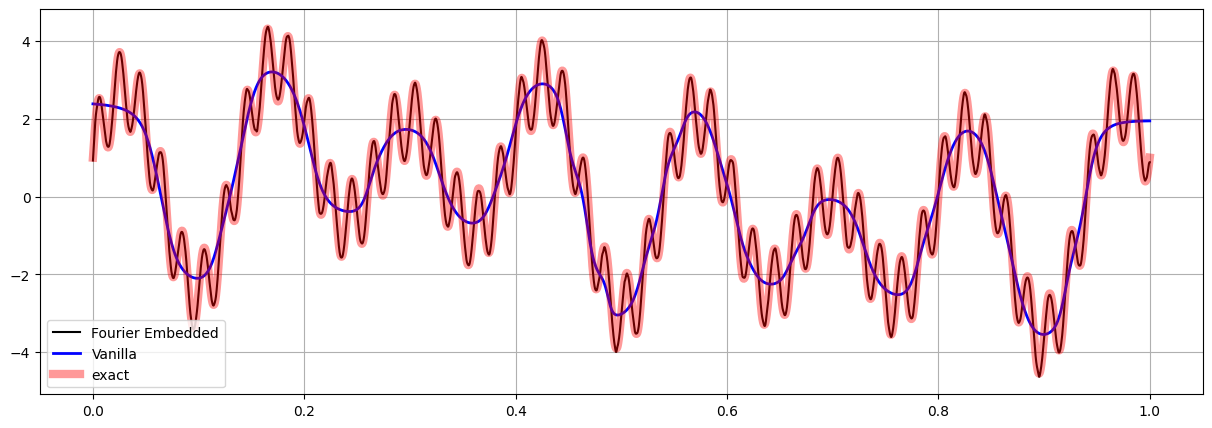

In [50]:
plt.figure(1, figsize=(15, 5))
# interpolate on finer grid
x_start, x_end = 0.0, 1.0
nx = 10000
xgrid = np.linspace(x_start, x_end, nx)
inputs = torch.tensor(xgrid).reshape(-1, 1)
plt.plot(xgrid, nn_fourier(inputs).detach().numpy().flatten(), color="black", label="Fourier Embedded");
plt.plot(xgrid, nn_vanilla(inputs).detach().numpy().flatten(), lw=2.0, color='blue', label="Vanilla");
plt.plot(xgrid, f(xgrid), lw=6.0, alpha=0.4, color="red", label="exact");
plt.legend();
plt.grid(True);